# X-Risk Exploratory Data Analysis

In this notebook we go through the existential risk database to learn about the estimates made by different people on the subject.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme(style='darkgrid')
orig_size = plt.rcParams['figure.figsize']

[11.7, 8.27]

In [4]:
# Load the data
df = pd.read_csv('./data/processed_estimates/all_estimates.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   estimator                      83 non-null     object 
 1   original_estimate              83 non-null     object 
 2   per_century_risk               83 non-null     float64
 3   estimate_confidence            83 non-null     object 
 4   conversion_confidence          83 non-null     object 
 5   reasoning                      83 non-null     object 
 6   risk_category                  83 non-null     object 
 7   estimate_confidence_numeric    83 non-null     int64  
 8   conversion_confidence_numeric  83 non-null     int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 6.0+ KB


In [5]:
# Get the unique risk categories
xrisk_categories = set(df['risk_category'])
print(f'There are {len(xrisk_categories)} unique risk categories:\n-\t{"\n-\t".join(xrisk_categories)}')

There are 9 unique risk categories:
-	dystopia
-	biorisk
-	natural_risks
-	miscellaneous
-	ai
-	war
-	climate_change
-	total
-	nanotechnology


In [6]:
categories_aliases = {
    "ai": "AI",
    "natural_risks": "Natural\nRisks",
    "nanotechnology": "Nanotech",
    "climate_change": "Climate\nChange",
    "war": "War",
    "miscellaneous": "Misc",
    "biorisk": "Biorisk",
    "total": "Total\nRisk",
    "dystopia": "Dystopia",
}
df['category_alias'] = df['risk_category'].map(categories_aliases)


Text(0.5, 0, 'Risk category')

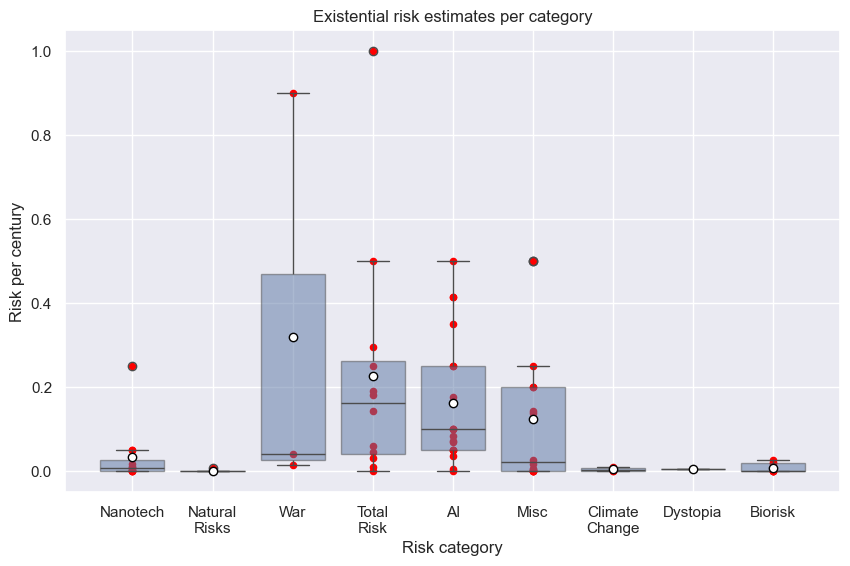

In [7]:
# Plot the risk categories as scatter plot.
# Make the boxes a little bit transparent.

ax = sns.boxplot(x='category_alias', y='per_century_risk', data=df, showmeans=True, meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"}, boxprops=dict(alpha=0.5))

df.plot(kind='scatter', x='category_alias', y='per_century_risk', color='red', figsize=(10, 6), ax=ax)

ax.set_title('Existential risk estimates per category')
ax.set_ylabel('Risk per century')
ax.set_xlabel('Risk category')
# Add box plot to indicate mean and standard distribution.

In [8]:
# Print the mean and standard deviation for each category
df_by_category = df.groupby('risk_category')['per_century_risk'].agg(['mean', 'std'])
df_by_category

,mean,std
risk_category,,
ai,0.161579,0.154940
biorisk,0.008032,0.010398
climate_change,0.004233,0.004815
dystopia,0.005000,NaN
miscellaneous,0.124088,0.170602
nanotechnology,0.032998,0.070677
natural_risks,0.000979,0.002549
total,0.225332,0.283787
war,0.318000,0.504194


Text(0.5, 0, 'Risk category')

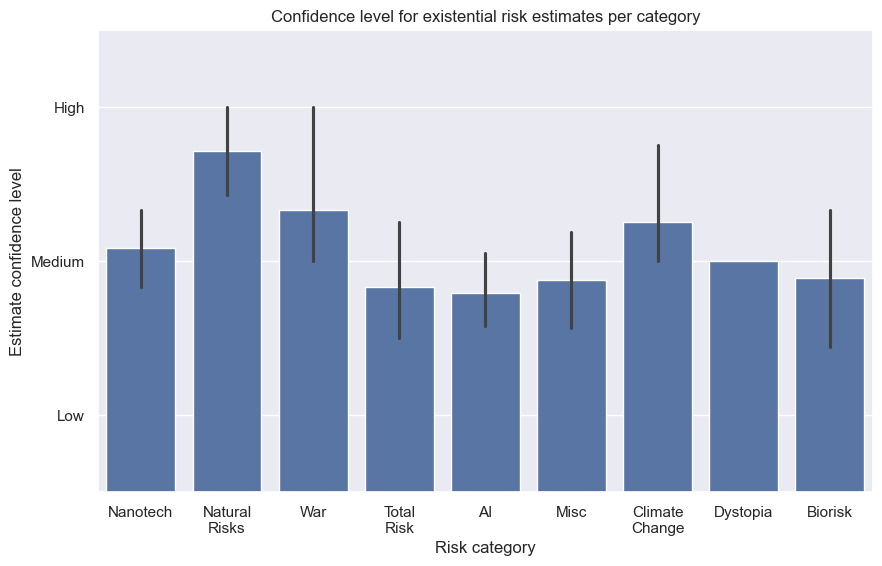

In [27]:
# Visualize the confidence level for each category in a 10 by 6 inches plot.
# Start plot from 1 since it's the lowest confidence level
sns.set_theme(rc={'figure.figsize': (10, 6)})
ax = sns.barplot(x='category_alias', y='estimate_confidence_numeric', data=df)
ax.set_ylim(0.5, 3.5)
ax.set_yticks([1, 2, 3], ['Low', 'Medium', 'High'])
ax.set_title('Confidence level for existential risk estimates per category')
ax.set_ylabel('Estimate confidence level')
ax.set_xlabel('Risk category')

It seems that the confidence level varies from category to category. Some categories do not have variation, like Dystopia, which only has one estimate.

Let's look at the conversion confidence now.

Text(0.5, 0, 'Risk category')

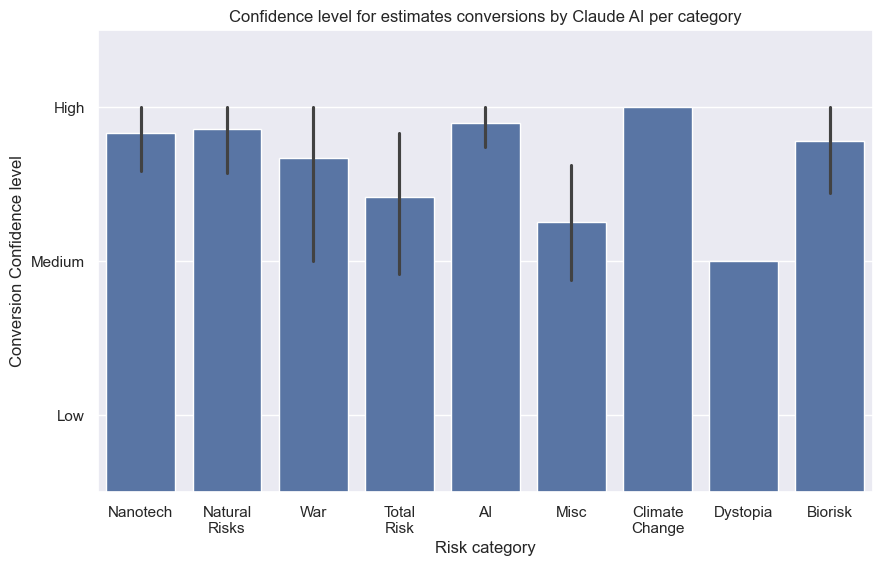

In [ ]:
# Visualize the confidence level for each category.
# Start plot from 1 since it's the lowest confidence level
ax = sns.barplot(x='category_alias', y='conversion_confidence_numeric', data=df)
ax.set_ylim(0.5, 3.5)
# Set y tick labels to Low, Medium and High using the mapping above
ax.set_yticks([1, 2, 3], ['Low', 'Medium', 'High'])
ax.set_title('Confidence level for estimates conversions by Claude AI per category')
ax.set_ylabel('Conversion confidence level')
ax.set_xlabel('Risk category')

Again, it seems that the confidence in the conversion by Claude AI is good for most risk categories, except for Dystopia, which only has one estimate and the confidence in the conversion is medium.

Let's use this information to create weighted averages using both the estimate confidence and the conversion confidence.

I'll use a weighted geometric mean model, that is based on a weight $\alpha$ that describes the "relevance" of one particular weight. Since we have two weight sources (estimate confidence and conversion confidence), we can create an aggregated weight based on the weighted geometric mean that we can use compute weighted averages.

The weighted geometric mean can be computed with:

$$
\begin{align}
w&=w_1^\alpha \cdot w_2^{1-\alpha}
\end{align}
$$

In [38]:
def weighted_geometric_mean(w1, w2, alpha):
    return (w1**alpha * w2**(1-alpha))
# We'll give more weight to the estimate confidence level
alpha = 0.6
df['weighted_confidence_mean'] = weighted_geometric_mean(df['estimate_confidence_numeric'], df['conversion_confidence_numeric'], alpha)
df['weighted_confidence_mean'].describe()

count    83.000000
mean      2.201257
std       0.558874
min       1.000000
25%       2.000000
50%       2.352158
75%       2.352158
max       3.000000
Name: weighted_confidence_mean, dtype: float64

Text(0.5, 0, 'Risk category')

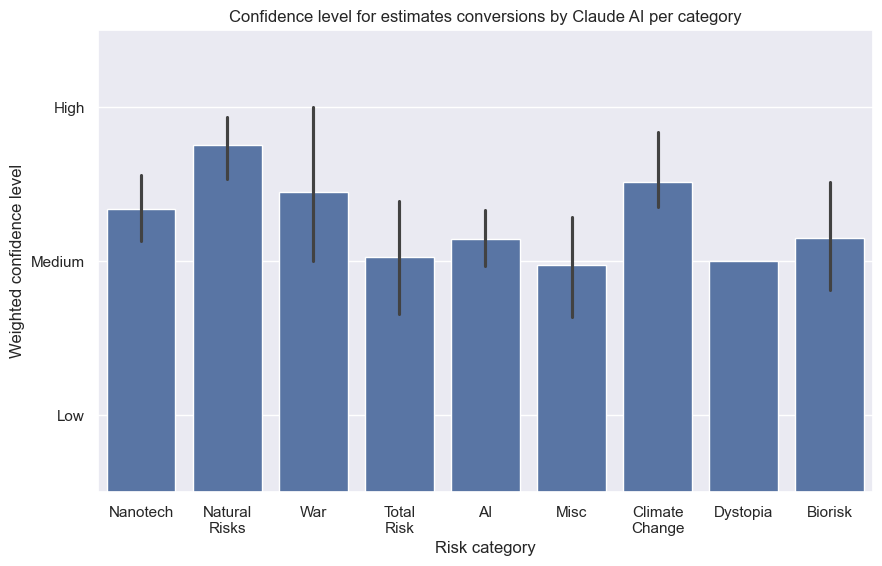

In [39]:
# Visualize the weighted confidence for each category.
# Start plot from 1 since it's the lowest confidence level
ax = sns.barplot(x='category_alias', y='weighted_confidence_mean', data=df)
ax.set_ylim(0.5, 3.5)
# Set y tick labels to Low, Medium and High using the mapping above
ax.set_yticks([1, 2, 3], ['Low', 'Medium', 'High'])
ax.set_title('Confidence level for estimates conversions by Claude AI per category')
ax.set_ylabel('Weighted confidence level')
ax.set_xlabel('Risk category')